In [1]:
pip install osmnx networkx matplotlib


[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


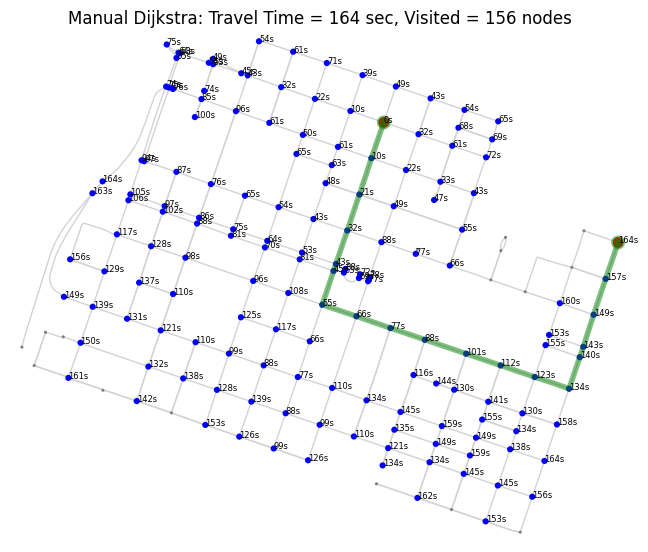

In [2]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import heapq

# Load the road network
place_name = "Downtown Sacramento, California, USA"
ox.settings.use_cache = False  # Disable caching
G = ox.graph_from_place(place_name, network_type='drive')
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

# Define start and destination coordinates
orig_point = (38.5816, -121.4944)
dest_point = (38.5758, -121.4788)

orig = ox.distance.nearest_nodes(G, X=orig_point[1], Y=orig_point[0])
dest = ox.distance.nearest_nodes(G, X=dest_point[1], Y=dest_point[0])

# --- Manual Dijkstra with tracking ---
def dijkstra_with_tracking(graph, start, goal):
    queue = [(0, start)]
    visited = set()
    travel_time = {start: 0}
    predecessor = {}
    visited_nodes = {}

    while queue:
        current_time, current_node = heapq.heappop(queue)

        if current_node in visited:
            continue

        visited.add(current_node)
        visited_nodes[current_node] = current_time

        if current_node == goal:
            break

        for neighbor in graph.successors(current_node):
            edge_data = graph.get_edge_data(current_node, neighbor)[0]
            time = edge_data.get('travel_time', float('inf'))
            new_time = current_time + time

            if neighbor not in travel_time or new_time < travel_time[neighbor]:
                travel_time[neighbor] = new_time
                predecessor[neighbor] = current_node
                heapq.heappush(queue, (new_time, neighbor))

    # Reconstruct path
    path = []
    current = goal
    while current != start:
        path.append(current)
        current = predecessor.get(current)
        if current is None:
            return None, {}, float('inf')  # no path
    path.append(start)
    path.reverse()
    return path, visited_nodes, travel_time[goal]

# Run Dijkstra
route, visited_nodes, total_time = dijkstra_with_tracking(G, orig, dest)

# --- Plotting ---
node_colors = []
node_sizes = []
for node in G.nodes():
    if node == orig or node == dest:
        node_colors.append('red')
        node_sizes.append(60)
    elif node in visited_nodes:
        node_colors.append('blue')
        node_sizes.append(20)
    else:
        node_colors.append('gray')
        node_sizes.append(5)

fig, ax = ox.plot_graph_route(
    G, route,
    route_linewidth=4,
    node_size=node_sizes,
    node_color=node_colors,
    bgcolor='white',
    edge_color='lightgray',
    route_color='green',
    show=False,
    close=False
)

# Optionally label visited nodes with cumulative travel time
for node, time in visited_nodes.items():
    x = G.nodes[node]['x']
    y = G.nodes[node]['y']
    ax.text(x, y, f"{int(time)}s", fontsize=6, color='black')

plt.title(f"Manual Dijkstra: Travel Time = {int(total_time)} sec, Visited = {len(visited_nodes)} nodes")
plt.show()


Using Manhattan Distance and choosing nodes which are closer to it so that we reduce the visited nodes and execute the query in lesser time

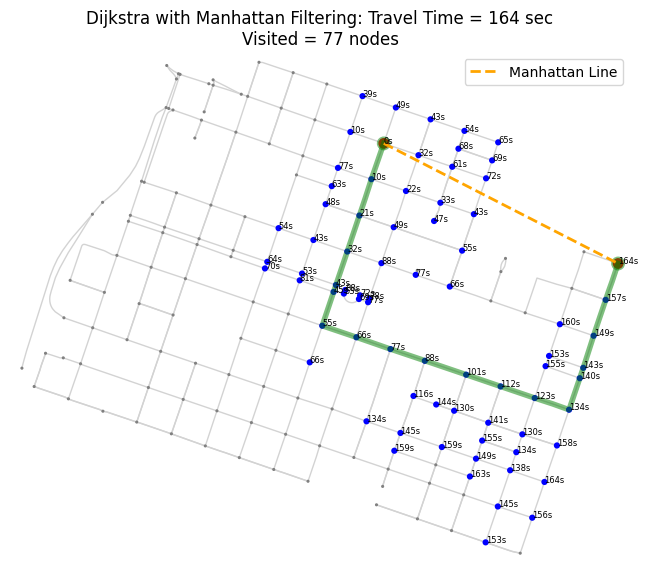

In [3]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import heapq

# Load the road network
place_name = "Downtown Sacramento, California, USA"
ox.settings.use_cache = False
G = ox.graph_from_place(place_name, network_type='drive')
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

# Define start and destination coordinates
orig_point = (38.5816, -121.4944)
dest_point = (38.5758, -121.4788)

orig = ox.distance.nearest_nodes(G, X=orig_point[1], Y=orig_point[0])
dest = ox.distance.nearest_nodes(G, X=dest_point[1], Y=dest_point[0])

# Manhattan Distance Function
def manhattan_distance(node1, node2):
    x1, y1 = G.nodes[node1]['x'], G.nodes[node1]['y']
    x2, y2 = G.nodes[node2]['x'], G.nodes[node2]['y']
    return abs(x1 - x2) + abs(y1 - y2)

# Modified Dijkstra with Manhattan Filtering
def dijkstra_with_manhattan_filter(graph, start, goal, tolerance=0.2):
    queue = [(0, start)]
    visited = set()
    travel_time = {start: 0}
    predecessor = {}
    visited_nodes = {}

    manhattan_total = manhattan_distance(start, goal)

    while queue:
        current_time, current_node = heapq.heappop(queue)

        if current_node in visited:
            continue

        visited.add(current_node)
        visited_nodes[current_node] = current_time

        if current_node == goal:
            break

        for neighbor in graph.successors(current_node):
            edge_data = graph.get_edge_data(current_node, neighbor)[0]
            time = edge_data.get('travel_time', float('inf'))
            new_time = current_time + time

            # Filter: only continue if neighbor is close to the Manhattan line
            total_dist = manhattan_distance(neighbor, goal)
            if total_dist <= (1 + tolerance) * manhattan_total:
                if neighbor not in travel_time or new_time < travel_time[neighbor]:
                    travel_time[neighbor] = new_time
                    predecessor[neighbor] = current_node
                    heapq.heappush(queue, (new_time, neighbor))

    # Reconstruct path
    path = []
    current = goal
    while current != start:
        path.append(current)
        current = predecessor.get(current)
        if current is None:
            return None, {}, float('inf')  # no path
    path.append(start)
    path.reverse()
    return path, visited_nodes, travel_time[goal]

# Run Modified Dijkstra
route, visited_nodes, total_time = dijkstra_with_manhattan_filter(G, orig, dest)

# --- Plotting ---
node_colors = []
node_sizes = []
for node in G.nodes():
    if node == orig or node == dest:
        node_colors.append('red')
        node_sizes.append(60)
    elif node in visited_nodes:
        node_colors.append('blue')
        node_sizes.append(20)
    else:
        node_colors.append('gray')
        node_sizes.append(5)

fig, ax = ox.plot_graph_route(
    G, route,
    route_linewidth=4,
    node_size=node_sizes,
    node_color=node_colors,
    bgcolor='white',
    edge_color='lightgray',
    route_color='green',
    show=False,
    close=False
)

# Manhattan Guide Line
x_vals = [G.nodes[orig]['x'], G.nodes[dest]['x']]
y_vals = [G.nodes[orig]['y'], G.nodes[dest]['y']]
ax.plot(x_vals, y_vals, color='orange', linestyle='--', linewidth=2, label='Manhattan Line')

# Label visited nodes with cumulative travel time
for node, time in visited_nodes.items():
    x = G.nodes[node]['x']
    y = G.nodes[node]['y']
    ax.text(x, y, f"{int(time)}s", fontsize=6, color='black')

plt.title(f"Dijkstra with Manhattan Filtering: Travel Time = {int(total_time)} sec\nVisited = {len(visited_nodes)} nodes")
plt.legend()
plt.show()


Used haversine formula 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


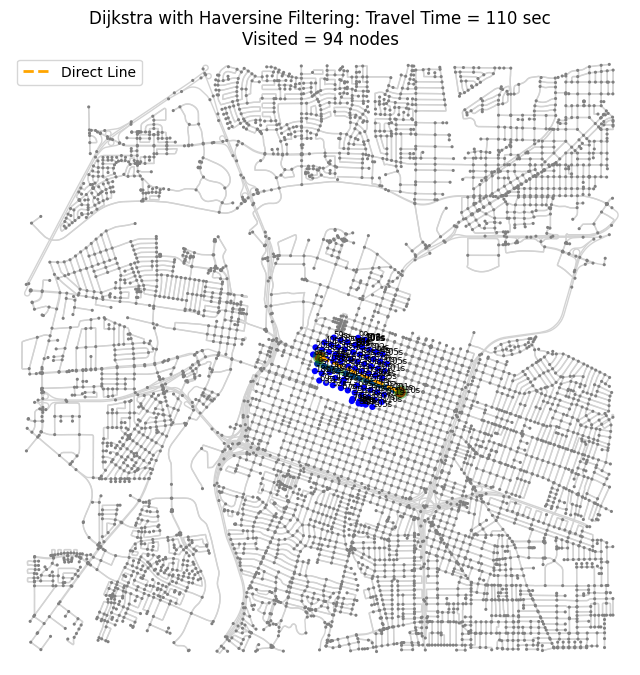

In [5]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import heapq
import math

# Load the road network using a larger radius area
center_point = (38.5816, -121.4944)  # Center around origin
ox.settings.use_cache = False  # Disable caching
G = ox.graph_from_point(center_point, dist=5000, network_type='drive')
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

# Define start and destination coordinates
orig_point = (38.5816, -121.4944)
dest_point = (38.5758, -121.4788)

orig = ox.distance.nearest_nodes(G, X=orig_point[1], Y=orig_point[0])
dest = ox.distance.nearest_nodes(G, X=dest_point[1], Y=dest_point[0])

# Haversine Distance Function
def haversine(lat1, lon1, lat2, lon2):
    R = 6371e3
    phi1, phi2 = math.radians(lat1), math.radians(lat2)
    dphi = math.radians(lat2 - lat1)
    dlambda = math.radians(lon2 - lon1)
    a = math.sin(dphi / 2)**2 + math.cos(phi1) * math.cos(phi2) * math.sin(dlambda / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return R * c

# --- Dijkstra with relaxed Haversine filtering ---
def dijkstra_with_haversine_filter(graph, start, goal, buffer_meters=400):
    queue = [(0, start)]
    visited = set()
    travel_time = {start: 0}
    predecessor = {}
    visited_nodes = {}

    lat1, lon1 = graph.nodes[start]['y'], graph.nodes[start]['x']
    lat2, lon2 = graph.nodes[goal]['y'], graph.nodes[goal]['x']
    total_haversine = haversine(lat1, lon1, lat2, lon2)

    while queue:
        current_time, current_node = heapq.heappop(queue)

        if current_node in visited:
            continue

        visited.add(current_node)
        visited_nodes[current_node] = travel_time[current_node]

        if current_node == goal:
            break

        for neighbor in graph.successors(current_node):
            edge_data = graph.get_edge_data(current_node, neighbor)[0]
            time = edge_data.get('travel_time', float('inf'))
            new_time = current_time + time

            lat, lon = graph.nodes[neighbor]['y'], graph.nodes[neighbor]['x']
            dist_via_neighbor = haversine(lat1, lon1, lat, lon) + haversine(lat, lon, lat2, lon2)
            deviation = abs(dist_via_neighbor - total_haversine)

            if deviation > buffer_meters:
                continue

            if neighbor not in travel_time or new_time < travel_time[neighbor]:
                travel_time[neighbor] = new_time
                predecessor[neighbor] = current_node
                heapq.heappush(queue, (new_time, neighbor))

    # Reconstruct path
    path = []
    current = goal
    while current != start:
        path.append(current)
        current = predecessor.get(current)
        if current is None:
            print("No path found with filtering. Falling back to full Dijkstra.")
            return nx.single_source_dijkstra(graph, start, goal, weight='travel_time')[1], visited_nodes, float('inf')
    path.append(start)
    path.reverse()
    return path, visited_nodes, travel_time[goal]

# Run the filtered Dijkstra
route, visited_nodes, total_time = dijkstra_with_haversine_filter(G, orig, dest)

# --- Plotting ---
node_colors = []
node_sizes = []
for node in G.nodes():
    if node == orig or node == dest:
        node_colors.append('red')
        node_sizes.append(60)
    elif node in visited_nodes:
        node_colors.append('blue')
        node_sizes.append(20)
    else:
        node_colors.append('gray')
        node_sizes.append(5)

fig, ax = ox.plot_graph_route(
    G, route,
    route_linewidth=4,
    node_size=node_sizes,
    node_color=node_colors,
    bgcolor='white',
    edge_color='lightgray',
    route_color='green',
    show=False,
    close=False
)

# Draw Manhattan-style straight line for reference
x_vals = [G.nodes[orig]['x'], G.nodes[dest]['x']]
y_vals = [G.nodes[orig]['y'], G.nodes[dest]['y']]
ax.plot(x_vals, y_vals, color='orange', linestyle='--', linewidth=2, label='Direct Line')

# Label visited nodes with cumulative travel time
for node, time in visited_nodes.items():
    x = G.nodes[node]['x']
    y = G.nodes[node]['y']
    ax.text(x, y, f"{int(time)}s", fontsize=6, color='black')

plt.title(f"Dijkstra with Haversine Filtering: Travel Time = {int(total_time)} sec\nVisited = {len(visited_nodes)} nodes")
plt.legend()
plt.show()
